Installing MMDetection

In [ ]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Download the PASCAL VOC 2007 dataset

In [ ]:
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null 2>&1

--2022-06-20 09:44:01--  http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar [following]
--2022-06-20 09:44:01--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  79.7MB/s    in 5.4s    

2022-06-20 09:44:07 (81.4 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



Data conversion using utilities that can convert Pascal voc format to Coco format

In [ ]:
!git clone https://github.com/ISSResearch/Dataset-Converters.git
!cd Dataset-Converters; pip install -r requirements.txt

In [ ]:
!mkdir ./converted_coco

mkdir: cannot create directory ‘./converted_coco’: File exists


In [ ]:
!cd Dataset-Converters;python convert.py --input-folder /content/VOCdevkit/VOC2007 \
                                         --output-folder /content/converted_coco \
                                         --input-format VOCSEGM \
                                         --output-format COCO \
                                         --copy

In [ ]:
!sudo apt-get install jq
!jq . /content/converted_coco/annotations/val.json > coco_anno_json

In [ ]:
!head -1500 coco_anno_json

{
  "images": [
    {
      "file_name": "000039.jpg",
      "height": 375,
      "width": 500,
      "id": 1
    },
    {
      "file_name": "000063.jpg",
      "height": 375,
      "width": 500,
      "id": 2
    },
    {
      "file_name": "000121.jpg",
      "height": 375,
      "width": 500,
      "id": 3
    },
    {
      "file_name": "000123.jpg",
      "height": 375,
      "width": 500,
      "id": 4
    },
    {
      "file_name": "000170.jpg",
      "height": 375,
      "width": 500,
      "id": 5
    },
    {
      "file_name": "000241.jpg",
      "height": 375,
      "width": 500,
      "id": 6
    },
    {
      "file_name": "000323.jpg",
      "height": 375,
      "width": 500,
      "id": 7
    },
    {
      "file_name": "000332.jpg",
      "height": 333,
      "width": 500,
      "id": 8
    },
    {
      "file_name": "000363.jpg",
      "height": 333,
      "width": 500,
      "id": 9
    },
    {
      "file_name": "000464.jpg",
      "height": 500,
      "width": 

In [ ]:
!grep -n "annotations" coco_anno_json

1283:  "annotations": [



Download the Pretrained model and set the Config, Dataset.


In [ ]:
!cd mmdetection; mkdir pretrained_model
!wget -O /content/mmdetection/pretrained_model/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2022-06-20 09:48:09--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/pretrained_model/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  9.33MB/s    in 27s     

2022-06-20 09:48:37 (8.98 MB/s) - ‘/content/mmdetection/pretrained_model/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class VOCDataset(CocoDataset):
  CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car',
               'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
               'tvmonitor')

In [ ]:
from mmcv import Config

config_file = "/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py"

mask_rcnn_cfg = Config.fromfile(config_file)
print(mask_rcnn_cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [ ]:
mask_rcnn_cfg.model.roi_head.bbox_head.num_classes=20
mask_rcnn_cfg.model.roi_head.mask_head.num_classes=20

mask_rcnn_cfg.dataset_type = 'VOCDataset'
mask_rcnn_cfg.data_root = '/content/converted_coco/'

mask_rcnn_cfg.data.train.type='VOCDataset'
mask_rcnn_cfg.data.train.data_root='/content/converted_coco/'
mask_rcnn_cfg.data.train.ann_file='annotations/train.json'
mask_rcnn_cfg.data.train.img_prefix='train'

mask_rcnn_cfg.data.val.type='VOCDataset'
mask_rcnn_cfg.data.val.data_root='/content/converted_coco/'
mask_rcnn_cfg.data.val.ann_file='annotations/val.json'
mask_rcnn_cfg.data.val.img_prefix='val'

mask_rcnn_cfg.evaluation.metric = ['bbox', 'segm']
mask_rcnn_cfg.evaluation.interval = 12

# Change learning rate Environment parameter settings
mask_rcnn_cfg.optimizer.lr = 0.02 / 8
mask_rcnn_cfg.lr_config.warmup = None
mask_rcnn_cfg.log_config.interval=10

mask_rcnn_cfg.lr_config.policy='step'

mask_rcnn_cfg.runner.max_epochs = 24

mask_rcnn_cfg.checkpoint_config.interval = 12

mask_rcnn_cfg.load_from = '/content/mmdetection/pretrained_model/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

mask_rcnn_cfg.device="cuda"

mask_rcnn_cfg.work_dir="./tutorial_exps"

from mmdet.apis import set_random_seed

# Set seed thus the results are more reproducible
mask_rcnn_cfg.seed = 0
set_random_seed(0, deterministic=False)
mask_rcnn_cfg.gpu_ids = range(1)

print(mask_rcnn_cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

datasets=[build_dataset(mask_rcnn_cfg.data.train)]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [ ]:
model=build_detector(mask_rcnn_cfg.model,train_cfg=mask_rcnn_cfg.get("train_cfg"),test_cfg=mask_rcnn_cfg.get("test_cfg"))
model.CLASSES=datasets[0].CLASSES

In [ ]:
import os
import mmcv

mmcv.mkdir_or_exist(os.path.abspath(mask_rcnn_cfg.work_dir))

In [ ]:
train_detector(model, datasets, mask_rcnn_cfg, distributed=False, validate=True)

2022-06-20 09:49:51,223 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-06-20 09:49:51,266 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/pretrained_model/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


2022-06-20 09:49:51,613 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([21, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([21]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([80, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([80]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 213/213, 8.8 task/s, elapsed: 24s, ETA:     0s

2022-06-20 10:01:41,101 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-06-20 10:01:41,558 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.795
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.580
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.518
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.573
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.606
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.308
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.26s).
Accumulating evaluation results...
DONE (t=0.18s).
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/usr/local/lib/python3.7/dist-packages/mmdet-2.25.0-py3.7.egg/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-06-20 10:01:42,262 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.734
 Average Precision  (AP) @[ IoU

DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.17s).


2022-06-20 10:01:49,766 - mmdet - INFO - Epoch [13][10/105]	lr: 2.500e-05, eta: 0:10:47, time: 0.747, data_time: 0.252, memory: 6035, loss_rpn_cls: 0.0013, loss_rpn_bbox: 0.0171, loss_cls: 0.0410, acc: 98.5645, loss_bbox: 0.0860, loss_mask: 0.1236, loss: 0.2691
2022-06-20 10:01:55,213 - mmdet - INFO - Epoch [13][20/105]	lr: 2.500e-05, eta: 0:10:42, time: 0.545, data_time: 0.031, memory: 6035, loss_rpn_cls: 0.0022, loss_rpn_bbox: 0.0143, loss_cls: 0.0662, acc: 97.5879, loss_bbox: 0.1361, loss_mask: 0.1403, loss: 0.3591
2022-06-20 10:02:00,369 - mmdet - INFO - Epoch [13][30/105]	lr: 2.500e-05, eta: 0:10:37, time: 0.516, data_time: 0.024, memory: 6035, loss_rpn_cls: 0.0010, loss_rpn_bbox: 0.0108, loss_cls: 0.0406, acc: 98.6523, loss_bbox: 0.0859, loss_mask: 0.1127, loss: 0.2509
2022-06-20 10:02:05,538 - mmdet - INFO - Epoch [13][40/105]	lr: 2.500e-05, eta: 0:10:31, time: 0.517, data_time: 0.023, memory: 6035, loss_rpn_cls: 0.0020, loss_rpn_bbox: 0.0120, loss_cls: 0.0428, acc: 98.5449, los

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 213/213, 9.0 task/s, elapsed: 24s, ETA:     0s

2022-06-20 10:13:35,047 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2022-06-20 10:13:35,496 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.796
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.587
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.278
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.578
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.27s).
Accumulating evaluation results...
DONE (t=0.17s).
Loading and preparing results...


/usr/local/lib/python3.7/dist-packages/mmdet-2.25.0-py3.7.egg/mmdet/datasets/coco.py:474: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  UserWarning)


DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2022-06-20 10:13:36,127 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.468
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.730
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.158
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large

DONE (t=0.42s).
Accumulating evaluation results...
DONE (t=0.16s).


load checkpoint from local path: /content/tutorial_exps/epoch_12.pth


/usr/local/lib/python3.7/dist-packages/mmdet-2.25.0-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


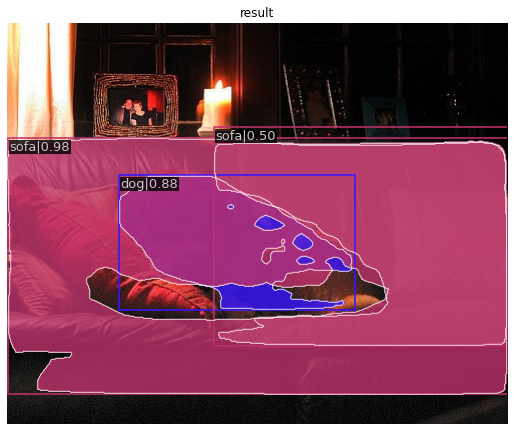

In [ ]:
from mmdet.apis import show_result_pyplot, init_detector, inference_detector
import cv2

checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

img = cv2.imread('/content/VOCdevkit/VOC2007/JPEGImages/000140.jpg')

model_ckpt = init_detector(mask_rcnn_cfg, checkpoint_file, device='cuda:0')

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

In [ ]:
!mkdir ./data
!wget -O ./data/cars.jpg https://raw.githubusercontent.com/HyeBin-Hub/Mask_R-CNN_Object_Detection/main/MMDetection_Mask_R-CNN_Object_Detection/images/cars.jpg

--2022-06-20 10:16:57--  https://raw.githubusercontent.com/HyeBin-Hub/Mask_R-CNN_Object_Detection/main/MMDetection_Mask_R-CNN_Object_Detection/images/cars.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141072 (138K) [image/jpeg]
Saving to: ‘./data/cars.jpg’

./data/cars.jpg     100%[===================>] 137.77K  --.-KB/s    in 0.01s   

2022-06-20 10:16:57 (10.8 MB/s) - ‘./data/cars.jpg’ saved [141072/141072]



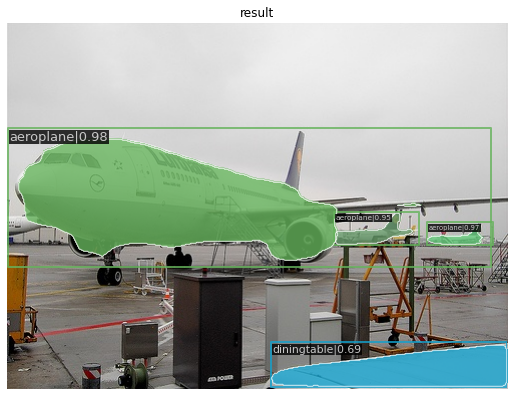

In [ ]:
img = cv2.imread('/content/VOCdevkit/VOC2007/JPEGImages/000033.jpg')

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.4)

In [ ]:
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [ ]:
import numpy as np

def get_detected_img(img_array,score_thr,model,is_caption,bbox,alpha):
  draw_img=img_array.copy()

  results=inference_detector(model,img_array)

  bboxes_inferences=results[0]
  maskes_inferences=results[1]

  for ind,bboxes_inference in enumerate(bboxes_inferences):
    if len(bboxes_inference)==0:
      continue

    maskes_inference=maskes_inferences[ind]

    for ind2,bbox_inference in enumerate(bboxes_inference):
      score = round(float(bbox_inference[4]),4)
      if score > score_thr:
        left=int(bbox_inference[0])
        top=int(bbox_inference[1])
        right=int(bbox_inference[2])
        bottom=int(bbox_inference[3])

        caption="{} : {}".format(labels_to_names_seq[ind],score)
        
        if bbox:
          cv2.rectangle(draw_img,(left,top),(right,bottom),(0,255,0),thickness=2)
          cv2.putText(draw_img,caption,(left,top-5),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)

        mask_inference=maskes_inference[ind2]

        masked_roi=draw_img[mask_inference]

        color_index=np.random.randint(0,len(colors)-1)
        color=colors[color_index]

        draw_img[mask_inference]=([0.3*color[0],0.3*color[1],0.3*color[2]]+alpha*masked_roi).astype(np.uint8)

        if is_caption:
          print(caption)

  return draw_img

(-0.5, 499.5, 365.5, -0.5)

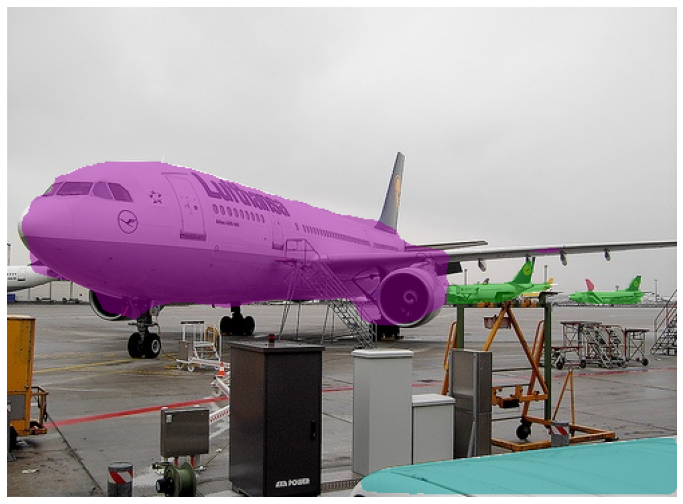

In [ ]:
import matplotlib.pyplot as plt

img = cv2.imread('/content/VOCdevkit/VOC2007/JPEGImages/000033.jpg')

detected_image=get_detected_img(img,0.4,model_ckpt,False,False,0.5)
detected_image=cv2.cvtColor(detected_image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,12))
plt.imshow(detected_image)
plt.axis("off")